<a href="https://colab.research.google.com/github/JMGO-coding/RL_GGM/blob/main/AproximacionFuncionesLineales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Aproximación de Funciones**

En este notebook se estudian algoritmos de Control con Aproximaciones, como SARSA semi-gradiente y Deep Q-Learning. Se probarán dichos algoritmos en el entorno Mountain Car de Gymnasium.


## **Preparamos el entorno MountainCar que se usará en el notebook**


In [18]:
#@title Importamos las librerias necesarias
import random
import gymnasium as gym
from gymnasium import ObservationWrapper
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
#@title Fijamos semilla

import os
import gc
import torch
import numpy as np
import gymnasium as gym

# Configuración del dispositivo (CPU o GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

# Liberación de memoria para evitar problemas de consumo en GPU
gc.collect() # Ejecuta el recolector de basura de Python
torch.cuda.empty_cache() # Vacía la caché de memoria en GPU

# Depuración de errores en CUDA
os.environ['CUDA_LAUNCH_BLOCKING'] = '1' # Muestra errores de CUDA en el punto exacto donde ocurren

# Configuración de la semilla para reproducibilidad
seed = 2024 # Se define una semilla fija

# Fijar la semilla en NumPy
np.random.seed(seed) # Para generar números aleatorios consistentes en NumPy
np.random.default_rng(seed) # Establece una instancia del generador de NumPy con la misma semilla

# Fijar la semilla en Python
os.environ['PYTHONHASHSEED'] = str(seed) # Evita variabilidad en hashing de Python

# Fijar la semilla en PyTorch
torch.manual_seed(seed) # Asegura resultados reproducibles en operaciones de PyTorch

if torch.cuda.is_available(): # Si hay GPU disponible
    torch.cuda.manual_seed(seed) # Fija la semilla para la GPU
    torch.backends.cudnn.deterministic = True # Hace las operaciones de CUDNN determinísticas
    torch.backends.cudnn.benchmark = False # Desactiva optimizaciones de CUDNN para evitar variabilidad

# Fijar la semilla en Gymnasium
def make_env(env_name):
    env = gym.make(env_name)
    env.reset(seed=seed) # Establece la semilla en el entorno de Gymnasium
    return env

# Ejemplo de creación de un entorno con semilla
env_name = "MountainCar-v0" # Cambiar según el entorno deseado
env = make_env(env_name)

Usando dispositivo: cpu


In [3]:
#@title Copiar el repositorio ``JMGO-coding/RL_GGM``.

!git clone https://github.com/JMGO-coding/RL_GGM.git
!cd RL_GGM/

Cloning into 'RL_GGM'...
remote: Enumerating objects: 748, done.
remote: Counting objects: 100% (81/81), done.
remote: Compressing objects: 100% (74/74), done.
remote: Total 748 (delta 55), reused 7 (delta 7), pack-reused 667 (from 1)
Receiving objects: 100% (748/748), 3.25 MiB | 16.64 MiB/s, done.
Resolving deltas: 100% (426/426), done.


In [4]:
#@title Importamos todas las clases y funciones

import sys

# Añadir los directorio fuentes al path de Python
sys.path.append('/content/RL_GGM')
sys.path.append('/content/RL_GGM/src')

# Verificar que se han añadido correctamente
print(sys.path)

from agents import AgentSemiGradientSARSA, AgentDeepQLearning
from wrappers import TileCodingEnv, MountainCarCustomRewards

['/content', '/env/python', '/usr/lib/python311.zip', '/usr/lib/python3.11', '/usr/lib/python3.11/lib-dynload', '', '/usr/local/lib/python3.11/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.11/dist-packages/IPython/extensions', '/root/.ipython', '/content/RL_GGM', '/content/RL_GGM/src']


In [5]:
#@title Cargamos el entorno
env = gym.make("MountainCar-v0", render_mode="rgb_array")
env.reset(seed=seed)

(array([-0.46483374,  0.        ], dtype=float32), {})

## Este es el entorno

/usr/local/lib/python3.11/dist-packages/pygame/pkgdata.py:25: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import resource_stream, resource_exists
/usr/local/lib/python3.11/dist-packages/pkg_resources/__init__.py:3154: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)
/usr/local/lib/python3.11/dist-packages/pkg_resources/__init__.py:3154: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google.cloud')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-pa

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]], dtype=uint8)
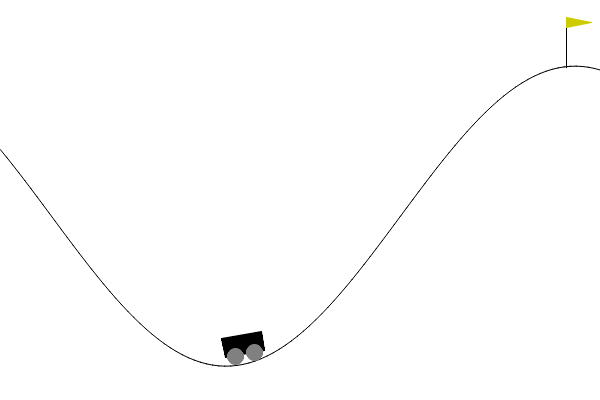

In [6]:
env.render()

### **Las acciones del entorno**

La acciones disponibles son:
- 0: Acelerar a la izquierda.
- 1: No acelerar
- 2: Acelerar a la derecha

In [7]:
env.action_space

Discrete(3)

### **Los estados del entorno**

Las observaciones es un ndarray con dimensión (2,) donde los elementos se corresponde a los siguientes valores:

| Número | Observación                          | Mínimo | Máximo | Unidad        |
|--------|--------------------------------------|--------|--------|---------------|
| 0      | Posición del coche en el eje x      | -1.2   | 0.6    | posición (m)  |
| 1      | Velocidad del coche                 | -0.07  | 0.07   | velocidad (v) |


In [8]:
env.observation_space, env.observation_space.low,  env.observation_space.high

(Box([-1.2  -0.07], [0.6  0.07], (2,), float32),
 array([-1.2 , -0.07], dtype=float32),
 array([0.6 , 0.07], dtype=float32))

### **Representaciones Gráficas**

Para comprobar el aprendizaje se mostrará la función $f(t)=\frac{\sum_{i=1}^t R_i}{t}$ para $t=1,2,\ldots, NumeroEpisodios$. La justificación es la siguiente. Como sabemmos que el retorno en el estados inicial 1 (pues no hay descuento) o 9, si se divide por el número de episodios ejecutados se calcular el porcentaje de recompensas positivas obtenidas. Dicho de otra forma, nos dirá el porcentaje de veces que el agente ha llegado al estado terminal.

También se muestra una gráfica con la longitud de los episodios en cada estado.

In [9]:
# @title Funciones para mostrar los resultados

def plot(list_stats):
  # Creamos una lista de índices para el eje x
  indices = list(range(len(list_stats)))

  # Creamos el gráfico
  plt.figure(figsize=(15, 8))
  plt.plot(indices, list_stats)

  # Añadimos título y etiquetas
  plt.title('Proporción de recompensas')
  plt.xlabel('Episodio')
  plt.ylabel('Proporción')

  # Mostramos el gráfico
  plt.grid(True)
  plt.show()

# Función para mostrar el tamaño de los episodios
def plot_episode_lengths(episode_lengths):
    """
    Grafica la longitud de los episodios
    """
    # Creamos una lista de índices para el eje x (número de episodios)
    indices = list(range(len(episode_lengths)))

    # Creamos el gráfico
    plt.figure(figsize=(15, 8))
    plt.plot(indices, episode_lengths)

    # Añadimos título y etiquetas
    plt.title('Longitud de los Episodios')
    plt.xlabel('Episodio')
    plt.ylabel('Longitud del Episodio')

    # Mostramos el gráfico
    plt.grid(True)
    plt.show()

# Histograma con la longitud de los episodios
def plot_episode_lengths_histogram(episode_lengths, bins=20):
    """
    Muestra un histograma de la frecuencia de las longitudes de episodios
    """
    plt.figure(figsize=(15, 8))
    plt.hist(episode_lengths, bins=bins, alpha=0.75, color='blue', edgecolor='black')

    plt.title('Distribución de la Longitud de los Episodios')
    plt.xlabel('Longitud del Episodio')
    plt.ylabel('Frecuencia')
    plt.grid(True)
    plt.show()

### **Preparación del entorno para grabar episodios de Gymnasium**

In [10]:
# Instalación de algunos paquetes.
!apt-get update

# Para visualizar en colab https://medium.com/@coldstart_coder/visually-rendering-python-gymnasium-in-jupyter-notebooks-4413e4087a0f
!apt-get install -y python-opengl ffmpeg
!apt-get install --upgrade cmake

# Para usar gymnasium[box2d]
!apt install swig xvfb
!pip install -U  pyvirtualdisplay

Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:3 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:4 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:5 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:11 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [2,988 kB]
Get:12 http://archive.ubuntu.com/ubuntu jammy-updates/restricted amd64 Packages [3,934 kB]
Get:13 http://archive.ubuntu.com/ubuntu jammy-updates/mu

In [11]:
!pip install gymnasium gymnasium[box2d]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 6.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 33.1 MB/s eta 0:00:00
  Created wheel for box2d-py: filename=box2d_py-2.3.5-cp311-cp311-linux_x86_64.whl size=2351177 sha256=22d107e4645c473b24caa19e016c17b515b99aabb2501099e69db68ee0bf526e
  Stored in directory: /root/.cache/pip/wheels/ab/f1/0c/d56f4a2bdd12bae0a0693ec33f2f0daadb5eb9753c78fa5308
Successfully built box2d-py


In [12]:
## Para visualizar en colab https://medium.com/@coldstart_coder/visually-rendering-python-gymnasium-in-jupyter-notebooks-4413e4087a0f
## https://medium.com/@coldstart_coder/dqn-algorithm-training-an-ai-to-land-on-the-moon-1a1307748ed9
# create a virtual display that will hold our video

# Google Colab se ejecuta en un entorno de servidor sin una interfaz gráfica de
# usuario (GUI). Para mostrar contenido visual como videos, se necesita una
# pantalla virtual para simular una pantalla.
# Esto permite que bibliotecas como gymnasium rendericen gráficos
# y los capturen para incrustarlos en el notebook.
#
# Este código crea una pantalla virtual oculta donde se puede renderizar contenido gráfico.

# pyvirtualdisplay es una biblioteca se usa para crear pantallas virtuales,
# que son esenciales para renderizar contenido gráfico en entornos sin interfaz gráfica.
from pyvirtualdisplay import Display

# visible=0 indica que la pantalla estará oculta (no visible para el usuario).
# Esto se debe a que Colab se ejecuta en un entorno de servidor sin una interfaz gráfica.
# size=(1400, 900) establece la resolución de la pantalla virtual a 1400x900 píxeles.
display = Display(visible=0, size=(1400, 900))

# inicia la pantalla virtual, preparándola para su uso.
display.start()


# Las siguientes líneas importan las bibliotecas necesarias para trabajar
# con entrada/salida, codificación base64 (usada para incrustar datos de video)
# y mostrar contenido HTML dentro del notebook de Colab.
import io
import base64
from IPython import display
from IPython.display import HTML

# Esta función mostrará un vídelo en la pantalla virtual, que será embembida en el notbook
def embed_video(video_file):
    # open and read the raw data from the video
    video_data = io.open(video_file, 'r+b').read()
    # now we have to encode the data into base64 to work
    # with the virtual display
    encoded_data = base64.b64encode(video_data)
    # now we use the display.display function to take some html
    # and the encoded data and embed the html into the notebook!
    display.display(HTML(data='''<video alt="test" autoplay
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
                </video>'''.format(encoded_data.decode('ascii'))))

In [13]:
import re # Para trabajar con expresiones regulares
import os # Para manipular archivos, directorios, variables de entorno y ejecutar comandos del SO

# Define la carpeta donde se guardarán los vídeos
video_folder = "videos"  # Nombre de la carpeta (puedes cambiarlo)

# Crea la carpeta si no existe
os.makedirs(video_folder, exist_ok=True) # exist_ok=True evita error si ya existe

# Retorna el nombre del último vídeo generado

def get_latest_episode_video_file(directory):
    # Expresión regular que coincide con el formato de los ficheros de video
    pattern = re.compile(r"rl-video-episode-(\d+)\.mp4")
    latest_file = None
    highest_episode = -1

    # Busca en el directorio
    for filename in os.listdir(directory):
        match = pattern.match(filename)
        if match:
            episode_number = int(match.group(1))  # Extrae el número de episodio
            # Comprobamos, para conseguir el número de episodio más alto.
            if episode_number > highest_episode:
                highest_episode = episode_number
                latest_file = os.path.join(directory, filename)  # Almacena el path completo

    return latest_file

## **1. SARSA semi-gradiente**

Para SARSA semi-gradiente, se calculará una función aproximada de la función de evaluación de estado-acción, usando una aproximación lineal.  
   Asumimos que
   $$
   \widehat{q}(s, a, \mathbf{w}) \;=\; \mathbf{w}^\top \mathbf{x}(s, a),
   $$
   donde $\mathbf{x}(s, a)$ es un **vector de características**.
   
Vamos a suponer que el vector de características viene dado por Tile Coding.

### **Tile Coding**

Tile Coding divide el espacio de estados  en regiones o "tiles" (azulejos).
Cada división recibe el nombre mosaicos (rejillas o tiling).

La idea principal es cubrir el espacio de estados con varias rejillas (tilings) que se superponen. Cada rejilla divide el espacio en celdas (tiles) y está ligeramente desplazada respecto a las otras. Esto permite que cada punto del espacio se asocie a varios tiles, uno por cada rejilla.



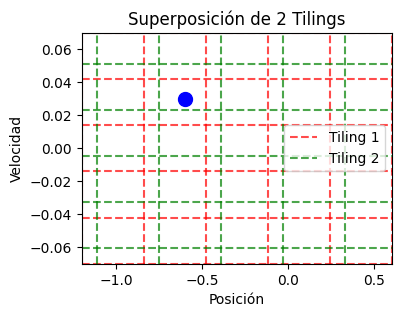

In [14]:
#@title Por ejemplo, podemos generar 2 tilings sbore el espacio $[-1.2, 0.6]\times [-0.07, 0.07]$ Cada color es un mosaico.

import numpy as np
import matplotlib.pyplot as plt

# Parámetros del espacio
x_min, x_max = -1.2, 0.6    # Rango para la posición
y_min, y_max = -0.07, 0.07  # Rango para la velocidad

# Número de celdas en cada dimensión y tilings
num_cells = 5       # se dividen en 5 celdas (25 posibles regiones)
num_tilings = 2     # cantidad de tilings

# Tamaño de cada celda
dx = (x_max - x_min) / num_cells
dy = (y_max - y_min) / num_cells

# Colores para cada tiling
colors = ['red', 'green', 'blue', 'orange']

# Crear la figura y el eje
fig, ax = plt.subplots(figsize=(4, 3))
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
ax.set_xlabel("Posición")
ax.set_ylabel("Velocidad")
ax.set_title("Superposición de 2 Tilings")

# Dibujar cada tiling con un offset progresivo
for i in range(num_tilings):
    # Calcular el offset para este tiling (una fracción del tamaño de celda)
    offset_x = (i / num_tilings) * dx
    offset_y = (i / num_tilings) * dy

    # Calcular las posiciones de las líneas de la grilla para cada tiling.
    # Se extiende ligeramente el rango para que se vean las líneas desplazadas.
    x_lines = np.arange(x_min + offset_x/(i+1), x_max + dx, dx)
    y_lines = np.arange(y_min + offset_y-offset_y/((2*i+1)), y_max + dy, dy)

    # Dibujar líneas verticales
    for xv in x_lines:
        ax.axvline(x=xv, color=colors[i], linestyle='--', alpha=0.7, label=f'Tiling {i+1}' if xv==x_lines[0] else "")
    # Dibujar líneas horizontales
    for yv in y_lines:
        ax.axhline(y=yv, color=colors[i], linestyle='--', alpha=0.7)

# Mostrar leyenda (cada tiling se etiqueta una sola vez)
ax.legend()

plt.scatter(-0.6, 0.03, color='blue', s=100)  # s es el tamaño del punto
plt.show()



Para un estado dado, representado con un punto, se determina en qué teselas cae en cada una de las rejillas. Esto permite definir un vector binario (o vector de características), $\mathbf{x}(s, a)$, donde cada componente indica si un tile específico está activo (por ejemplo, con valor 1) o no (valor 0).
La mayoría de componentes son 0 y unas pocas son 1, correspondientes a los tiles activos).

### **Creamos una Tile Coding para los estados de MountainCar**

TileCodingEnv es un envoltorio para un entorno Gym que aplica la técnica de Tile Coding.

Esta técnica discretiza observaciones continuas en múltiples rejillas (tilings) desplazadas, permitiendo representar el espacio de estados de forma que se faciliten la generalización y el aprendizaje.

- Se ha implementado un Wrapper `TileCodingEnv` sobre el espacio de observaciones.
- Vamos a generar varios tilings (mosaicos).

Para lograr que el agente aprenda más rápido, se han modificado las recompensas:

- Velocidad: Se agrega $50 \cdot |velocidad|$, lo que incentiva al agente a moverse rápido en lugar de quedarse atrapado.
- Progreso: Se suma $5 \cdot (posición - posición\_anterior)$, lo que premia si avanza hacia la cima y castiga si retrocede.
- Objetivo final: Se mantiene $+100$ si alcanza la cima.
- Pasos: Se mantiene la penalización de $-1$ por cada paso.

In [15]:
#@title Cargamos el entorno
env = gym.make("MountainCar-v0", render_mode = "rgb_array")
env.reset(seed=seed)
env._max_episode_steps = 1000  # Cambiar el límite de pasos

# Aplica el wrapper para modificar las recompensas
env = MountainCarCustomRewards(env, negative_reward=-1, goal_reward=100, velocity_factor=50, progress_factor=5)

In [16]:
#@title Generamos  mosaicos (tilings) con varios intervalos por dimensión. Al nuevo espacio lo llamaremos *tcenv*
tilings = 10  # Número de mosaicos
bins = np.array([20, 20])  # Número de intervalos en cada dimensión. 20 en cada una
low = env.observation_space.low
high = env.observation_space.high
tcenv = TileCodingEnv(env, bins=bins, low=low, high=high, n=tilings)

In [17]:
#@title Comparamos el entorno original con el entorno con estados agregados

print(f"El espacio de observaciones original es: {env.observation_space}, \n\
Un estado para este espacio original es: {env.step(env.action_space.sample())}")
print(f"\nEl espacio de estados modificado es: {tcenv.observation_space}. Mosaicos: {tcenv.n_tilings} \n\
Un estado para este nuevo espacio es: {tcenv.step(tcenv.action_space.sample())[0]} \n\
Cada pareja es la 'celda' correspondiente a cada mosaico")
print(f"Las caracterísiticas observadas han sido {tcenv.last_active_features} sobre {np.prod(tcenv.bins)*tcenv.n_tilings} parámetros")

El espacio de observaciones original es: Box([-1.2  -0.07], [0.6  0.07], (2,), float32), 
Un estado para este espacio original es: (array([-4.6527219e-01, -4.3845834e-04], dtype=float32), -0.9780770827783272, False, False, {})

El espacio de estados modificado es: MultiDiscrete([20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20]). Mosaicos: 10 
Un estado para este nuevo espacio es: [(8, 10), (8, 9), (8, 9), (8, 9), (7, 9), (7, 9), (7, 9), (7, 9), (7, 9), (7, 9)] 
Cada pareja es la 'celda' correspondiente a cada mosaico
Las caracterísiticas observadas han sido [170, 569, 969, 1369, 1749, 2149, 2549, 2949, 3349, 3749] sobre 4000 parámetros


### **Cómo usar el código para obtener una aproximación de Q(s,a)**


Queremos calcular $\widehat{q}(s, a, \mathbf{w}) = \displaystyle\mathbf{w}^\top \mathbf{x}(s, a) = \sum_{i=1}^d w_i \cdot x_i(s, a)$


Para cada acción, la  función tendrá tantos pesos como el número total de tiles (celdas) generadas en todos los tilings. Por tanto, los pesos $\mathbf{w}$  se definen como una matriz de dimensiones $total\_features \times n\_actions$.

```
# Número de acciones en el entorno original
num_actions = tcenv.env.action_space.n  

# Número total de características en el aproximador lineal:
total_features = tcenv.n_tilings * np.prod(tcenv.bins)

# Inicializamos los pesos (por ejemplo, en cero)
w = np.zeros((total_features, num_actions))
```

Cada fila de `w` corresponde a una feature (un tile específico de un tiling) y cada columna a una acción.

Como las características son binarias, la evaluación de $\widehat{q}$ se reduce a sumar los pesos que se corresponde a las características activas:
$$
\widehat{q}(s, a, \mathbf{w}) = \sum_{i \in \text{features_activas}(s)} w_{i,a}.
$$



 Así, cuando estés en un estado $s$, el método `tcenv.observation(s)` (y, por extensión, `tcenv.last_active_features`) te proporcionará los índices de los tiles activos en ese estado. Por ejemplo, si `tcenv.last_active_features` retorna `[35, 142, 18, 600]` y seleccionas la acción $a$, entonces

```python
q_sa = w[35, a] + w[142, a] + w[18, a] + w[600, a]
```

Eso es lo que define y cómo se utiliza la matriz de pesos $\mathbf{w}$ según el código y la aproximación lineal con Tile Coding.

## ¿Como usarlo para SARSA o Q-Learning?


Recordemos la teoría. Supongamos que se quiere aplicar semigradiente-SARSA

1. **Regla de actualización general (semigradiente SARSA)**  
   Se usa la siguiente ecuación de actualización para los pesos $\mathbf{w}$:

   $$
   \mathbf{w} \;\leftarrow\;
   \mathbf{w}
   \;+\; \alpha \Bigl[
     R + \gamma \,\widehat{q}(S', A', \mathbf{w})
     \;-\; \widehat{q}(S, A, \mathbf{w})
   \Bigr]
   \,\nabla_{\mathbf{w}} \widehat{q}(S, A, \mathbf{w})
   $$
   
   Siendo $\alpha$ la tasa de aprendizaje, $\gamma$ el factor de descuento, y $R$ la recompensa obtenida en la transición $(S, A) \to (S', A')$.


2. **La función aproximada**  que estamos asumiendo es
   $
   \widehat{q}(s, a, \mathbf{w}) \;=\; \mathbf{w}^\top \mathbf{x}(s, a),
   $
   donde $\mathbf{x}(s, a)$ es un **vector de características**. Ya sabemos cómo calcular este valor.

3. **Gradiente de $\widehat{q}$**  
   Se necesita calcular $\nabla_{\mathbf{w}} \widehat{q}(S, A, \mathbf{w})$, pero  dado que $\widehat{q}$ es lineal, la derivada con respecto a $\mathbf{w}$ es simplemente:
   $$
   \nabla_{\mathbf{w}} \widehat{q}(s, a, \mathbf{w})
   \;=\;
   \mathbf{x}(s, a).
   $$
   - En Tile Coding, $\mathbf{x}(s,a)$ será  un vector con 1s en los índices de los tiles activos y 0s en el resto.

3. **Regla de actualización específica (semigradiente SARSA)**

   Al reemplazar $\nabla_{\mathbf{w}} \widehat{q}(S, A, \mathbf{w})$ por $\mathbf{x}(S, A)$, se obtiene:

   $$
   \mathbf{w}
   \;\leftarrow\;
   \mathbf{w}
   \;+\;
   \alpha \,\Bigl[
     R + \gamma \,\widehat{q}(S', A', \mathbf{w}) - \widehat{q}(S, A, \mathbf{w})
   \Bigr]
   \,\mathbf{x}(S, A).
   $$

   A menudo se define el **TD-error** $\delta$ como:
   $$
   \delta
   \;=\;
   R + \gamma \,\widehat{q}(S', A', \mathbf{w})
       - \widehat{q}(S, A, \mathbf{w}).
   $$
   Entonces, la actualización es:
   $$
   \mathbf{w}
   \;\leftarrow\;
   \mathbf{w}
   \;+\; \alpha \,\delta \,\mathbf{x}(S, A).
   $$

  Particularizando a Tile Coding:  
   - $\mathbf{x}(S,A)$ es un vector de dimensión $d$ (el total de “features” o tiles posibles).  
   - En Tile Coding, solo los tiles **activos** tienen valor 1; el resto son 0.  
   - Esto significa que, para cada transición, **solo se actualizan los pesos correspondientes a los tiles activos**.  

  En la práctica, si $\mathbf{x}(S, A)$ tuviera posiciones $\{i_1, i_2, \dots, i_k\}$ activas (con valor 1), la actualización es:
   $$
   w_{i_j}
   \;\leftarrow\;
   w_{i_j}
   \;+\; \alpha \,\delta
   \quad\text{para cada } j=1,\dots,k.
   $$

In [18]:
# @title Aprendizaje
agent = AgentSemiGradientSARSA(tcenv, epsilon=1, decay=True, discount_factor=0.99, alpha = 0.1)
agent.reset()
agent.train(num_episodes=10000)

# Estadísticos
list_stats, episode_lengths = agent.get_stats()

 10%|█         | 1001/10000 [05:51<57:07,  2.63it/s]

Episode 1001/10000, total reward: -755.8280394940994


 20%|██        | 2001/10000 [11:21<55:27,  2.40it/s]

Episode 2001/10000, total reward: 305.0877684818988


 30%|███       | 3003/10000 [15:28<14:45,  7.90it/s]

Episode 3001/10000, total reward: 391.955263376527


 40%|████      | 4002/10000 [17:13<07:44, 12.91it/s]

Episode 4001/10000, total reward: 135.5271545865835


 50%|█████     | 5001/10000 [18:39<06:43, 12.40it/s]

Episode 5001/10000, total reward: 87.33945353054878


 60%|██████    | 6002/10000 [19:55<04:10, 15.97it/s]

Episode 6001/10000, total reward: 106.2925391754543


 70%|███████   | 7002/10000 [21:04<03:59, 12.53it/s]

Episode 7001/10000, total reward: 113.3374380417954


 80%|████████  | 8004/10000 [22:10<01:46, 18.81it/s]

Episode 8001/10000, total reward: 137.17458671110217


 90%|█████████ | 9002/10000 [23:10<01:22, 12.10it/s]

Episode 9001/10000, total reward: 148.5900950335781


100%|██████████| 10000/10000 [24:09<00:00,  6.90it/s]

Average return over 10000 episodes: 71.47338742393379


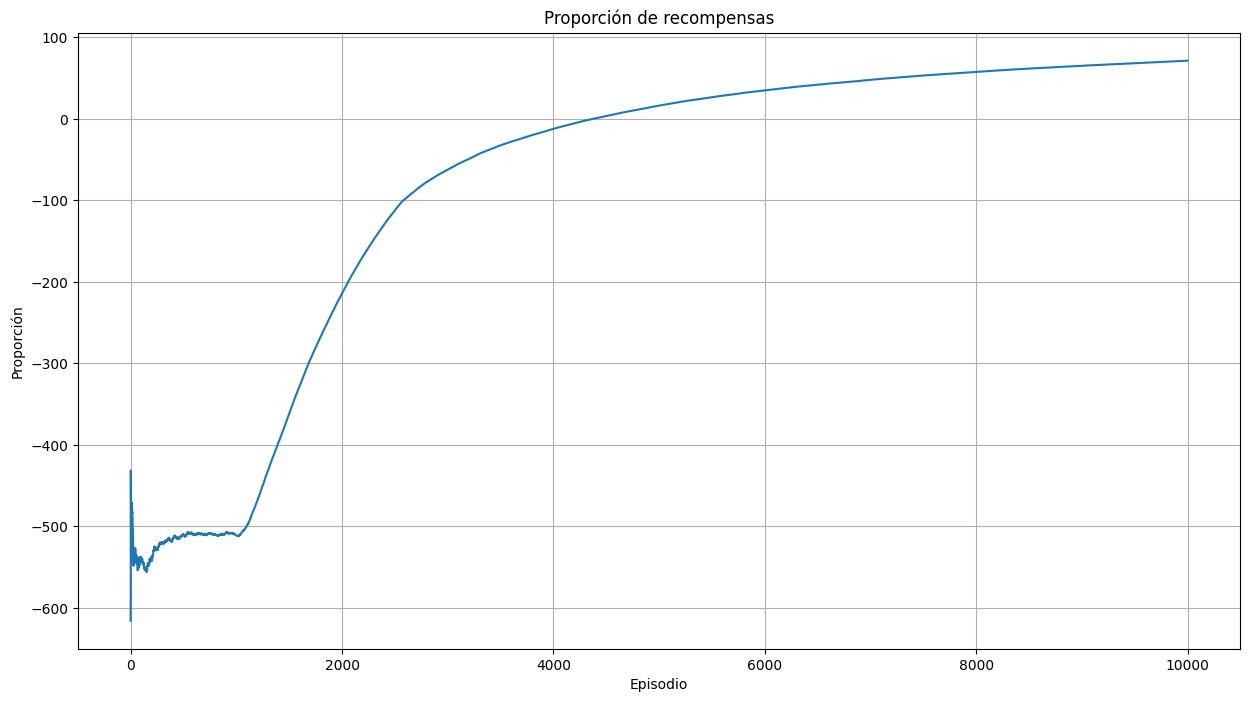

Máxima proporción: 71.47338742393363


In [19]:
#@title Proporción de aciertos por número de episodios

plot(list_stats)
print(f"Máxima proporción: {list_stats[-1]}")

Al observar la gráfica de proporción de recompensas, se puede apreciar como al principio, en los primeros episodios, esta proporción es bastante baja, y de hecho, negativa, y además oscila, pero a partir de aproximadamente el episodio 1000, comienza a crecer considerablemente, alcanzando incluso valores positivos para la recompensa. Esto es una clara muestra de que el agente está aprendiendo, seguramente gracias al wrapper que hemos implementado para modificar las recompensas, especialmente favoreciendo el aumento de la velocidad.

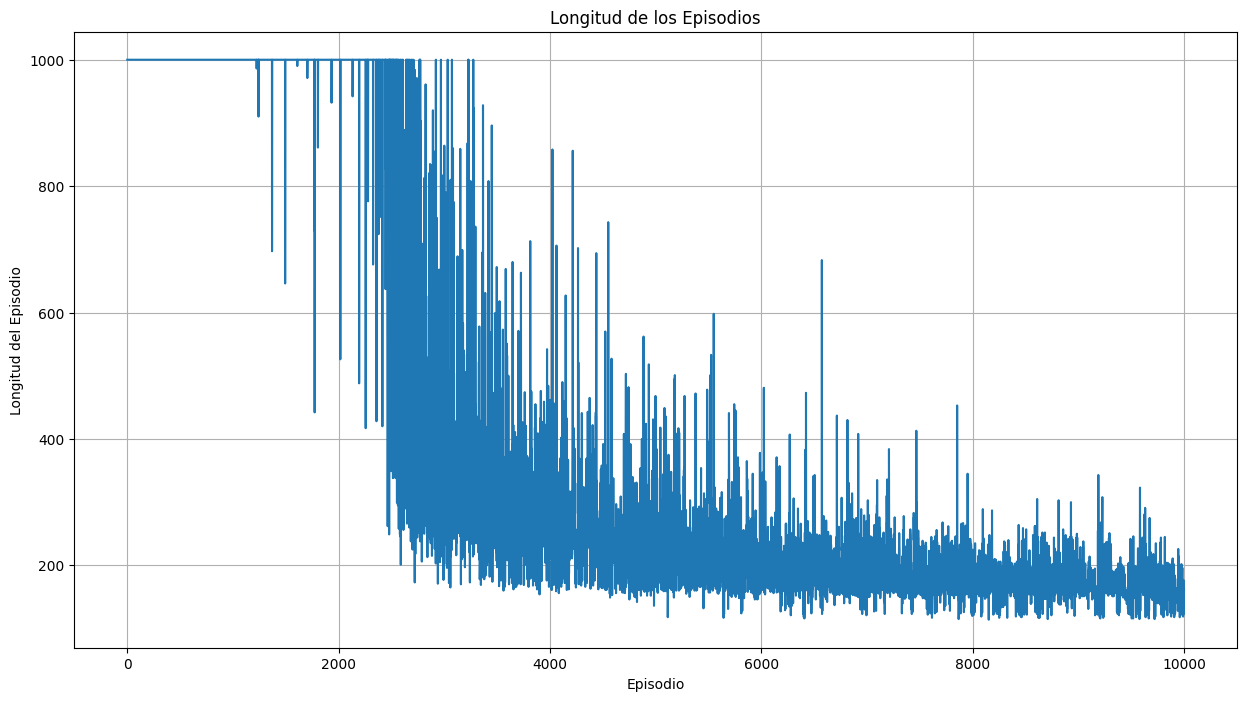

In [20]:
#@title Longitud de los episodios

plot_episode_lengths(episode_lengths)

En la gráfica anterior se muestra la longitud de los episodios de entrenamiento. Se observa como los primeros episodios duran 1000 pasos, que de hecho es el máximo que hemos seleccionado para la longitud de los episodios. Sin embargo, a partir del episodio 2000 aproximadamente, la longitud de los episodios empieza a dismunuir considerablemnete, hasta que finalmente se estabiliza alrededor de los 100 pasos por episodio. Esto es una clara muestra de que a lo largo del entrenamiento, el agente está aprendiendo a llegar a la meta cada vez en menos pasos.

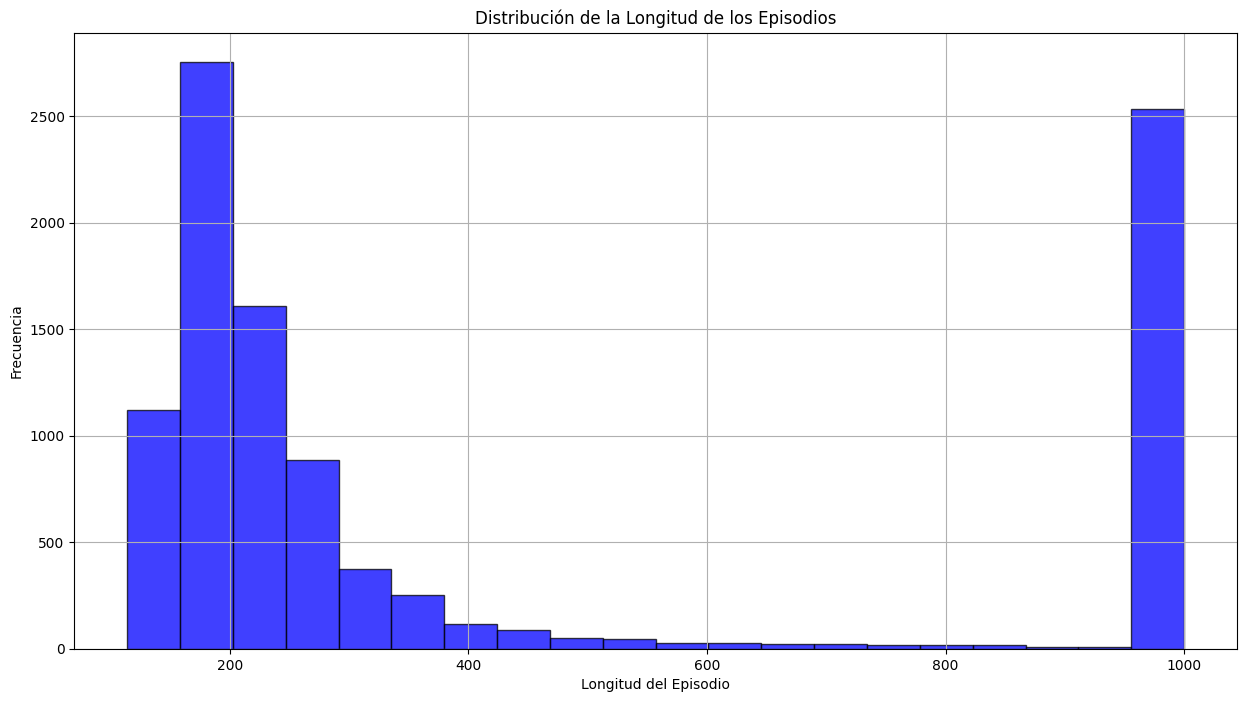

In [21]:
#@title Histograma con la longitud de los episodios

plot_episode_lengths_histogram(episode_lengths)

Al observar la distribución de la longitud de los episodios, podemos observar que algo más de 2500 episodios tienen una longitud de unos 1000 pasos, los cuales se corresponden con los episodios del principio del entrenamiento. Sin embargo, el resto del histograma se concentra alrededor de los 150 o 200 pasos. Estos episodios con menos pasos se corresponden con cuando el agente empieza a lograr llegar a la meta, y por tanto comienza a aprender, disminuyendo progresivamente la longitud de los episodios conforme descubre que aumentando la velocidad gana una mayor recompensa.

In [22]:
# @title Simulaciones en vídeo
import gymnasium as gym
from gymnasium.wrappers import RecordEpisodeStatistics, RecordVideo

# Solo grabamos 10 episodios, por ejemplo
trigger = lambda episode_id: episode_id < 10  # Graba solo los primeros 10 episodios

# Aplica el wrapper RecordVideo para grabar vídeos
env = gym.wrappers.RecordVideo(
    tcenv,
    video_folder=video_folder,
    episode_trigger=trigger,  # Graba solo los primeros 10 episodios
)

num_episodes = 2 # Número de episodios a grabar
#observation, info = env.reset(seed=42)
for episode in range(num_episodes):
    observation, info = env.reset(seed=seed)
    episode_over = False
    while not episode_over:

        active_features = tcenv.last_active_features

        # Renderiza el frame actual, esto lo guardará en el archivo de video.
        env.render()

        # El agente elige la acción usando la política entrenada
        action = agent.get_action(active_features)

        # Ejecuta un paso en el entorno con la acción seleccionada.
        # Obtiene la siguiente observación, la recompensa,
        # y si el episodio ha terminado (terminated) o ha sido truncado (truncated).
        observation, reward, terminated, truncated, info = env.step(action)

        # Verifica si el episodio ha terminado, ya sea por terminación o truncamiento.
        episode_over = terminated or truncated


env.close() # Importante cerrar el entorno, ¡esto finaliza la grabación de vídeo!
print(f"Grabación de episodios completada. Vídeos guardados en la carpeta '{video_folder}'")

/usr/local/lib/python3.11/dist-packages/gymnasium/wrappers/rendering.py:283: UserWarning: WARN: Overwriting existing videos at /content/videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
/usr/local/lib/python3.11/dist-packages/moviepy/config_defaults.py:1: DeprecationWarning: invalid escape sequence '\P'
  """


Grabación de episodios completada. Vídeos guardados en la carpeta 'videos'


In [23]:
latest_file = get_latest_episode_video_file(video_folder)
print(f"Último vídeo: {latest_file}") # outputs: ./video/rl-video-episode-4.mp4
embed_video(latest_file)

Último vídeo: videos/rl-video-episode-1.mp4


En el vídeo de la simulación realizada tras el entrenamiento del agente, se puede observar cómo el coche aumenta rápidamente su velocidad y alcanza la meta en a penas 5 segundos. Esto se debe al wrapper que utilizamos, que otorga recompensas adicionales por incrementar la velocidad y por avanzar hacia la cima. Gracias a estas recompensas, el agente ha aprendido a optimizar su comportamiento, logrando llegar a la meta en un tiempo bastante reducido.

## **2. Deep Q-Learning**

**Deep Q-Learning (DQN)** es una extensión de Q-Learning clásico que utiliza redes neuronales profundas para aproximar $q(s, a)$ con una red neuronal que:

- **Toma un estado s como entrada**:
  - Un vector (en entornos simples), una imagen (en videojuegos o tareas visuales).
  
- **La salida produce un vector de valores q(s, a) para todas las acciones posibles a**.

La función de aproximación $\hat{q}(s, a; w)$ es una red neuronal donde $w$ son los parámetros de la red.

**Características de DQN**:
 - La red se entrena para minimizar el error cuadrático medio (MSE) entre la salida actual y el objetivo:
$$L(w) = \mathbb{E}_{(s, a, r, s′)}[(y − \hat{q}(s, a; w))^2]$$
  donde:
  - $\hat{q}(s, a; w)$ es la estimación actual.
  - El target es una copia congelada de la red principal.
    - $y = r + \gamma \max_{a′} \hat{q}(s′, a′; w_{target})$.
    - $w_{target}$ son los parámetros de una red separada (target network).
  
- Aplica **Replay Buffer** (muestreo).


In [14]:
#@title Cargamos el entorno
env = gym.make("MountainCar-v0", render_mode = "rgb_array")
env.reset(seed=seed)
env._max_episode_steps = 1000  # Cambiar el límite de pasos

# Aplica el wrapper para modificar las recompensas
env = MountainCarCustomRewards(env, negative_reward=-1, goal_reward=100, velocity_factor=50, progress_factor=5)

In [16]:
# @title Aprendizaje
agent = AgentDeepQLearning(env, epsilon=1, decay=True, discount_factor=0.99, alpha = 0.1, memory_capacity = 10000, batch_size = 32, learning_rate = 0.0005)
agent.reset()
agent.train(num_episodes=10000)

# Estadísticos
list_stats, episode_lengths = agent.get_stats()

 11%|█         | 11/100 [00:18<02:33,  1.73s/it]

success: -644.0707777049397, epsilon: 1.0


 21%|██        | 21/100 [00:35<02:13,  1.69s/it]

success: -593.7703636398157, epsilon: 1.0


 31%|███       | 31/100 [00:56<02:08,  1.86s/it]

success: -568.6574712404132, epsilon: 1.0


 41%|████      | 41/100 [01:14<01:51,  1.89s/it]

success: -560.6436293124758, epsilon: 1.0


 51%|█████     | 51/100 [01:33<01:29,  1.82s/it]

success: -548.2243320860532, epsilon: 1.0


 61%|██████    | 61/100 [01:52<01:12,  1.87s/it]

success: -522.5506674167233, epsilon: 1.0


 71%|███████   | 71/100 [02:11<00:52,  1.80s/it]

success: -524.4347287909716, epsilon: 1.0


 81%|████████  | 81/100 [02:28<00:31,  1.67s/it]

success: -524.7597527207885, epsilon: 1.0


 91%|█████████ | 91/100 [02:44<00:14,  1.63s/it]

success: -530.9463291697685, epsilon: 1.0


100%|██████████| 100/100 [03:00<00:00,  1.80s/it]


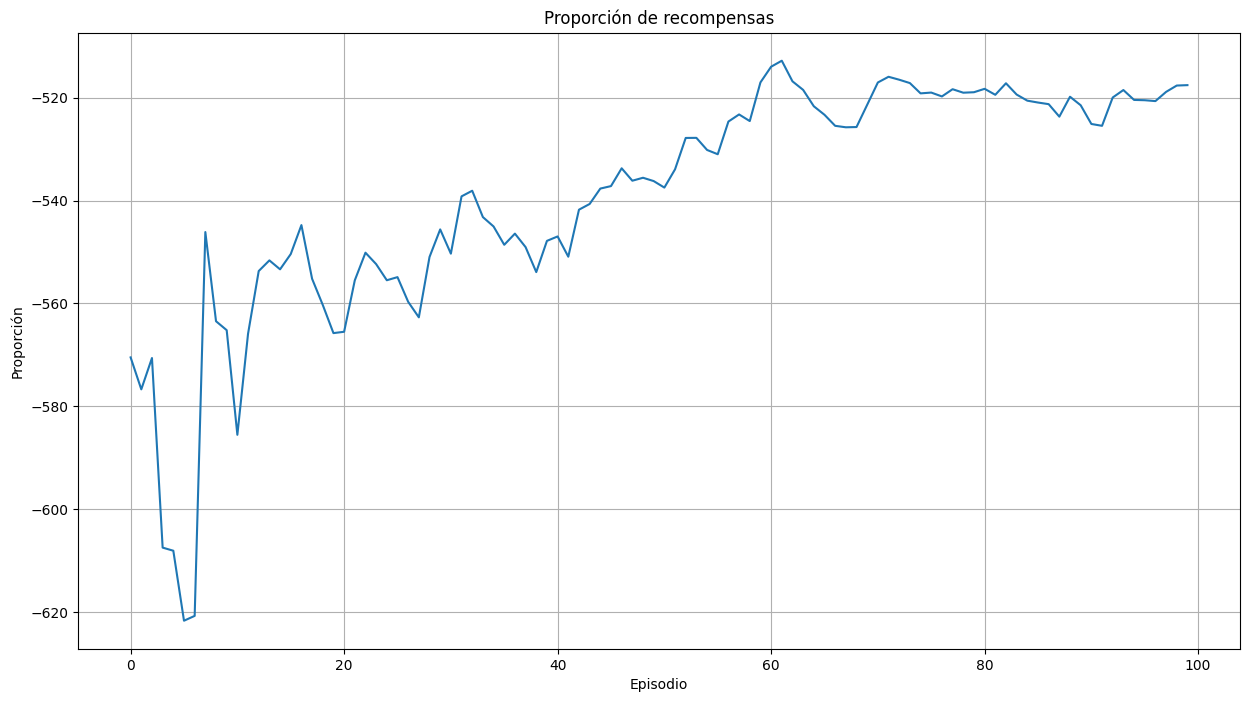

Máxima proporción: -517.5663221240055


In [19]:
#@title Proporción de aciertos por número de episodios

plot(list_stats)
print(f"Máxima proporción: {list_stats[-1]}")

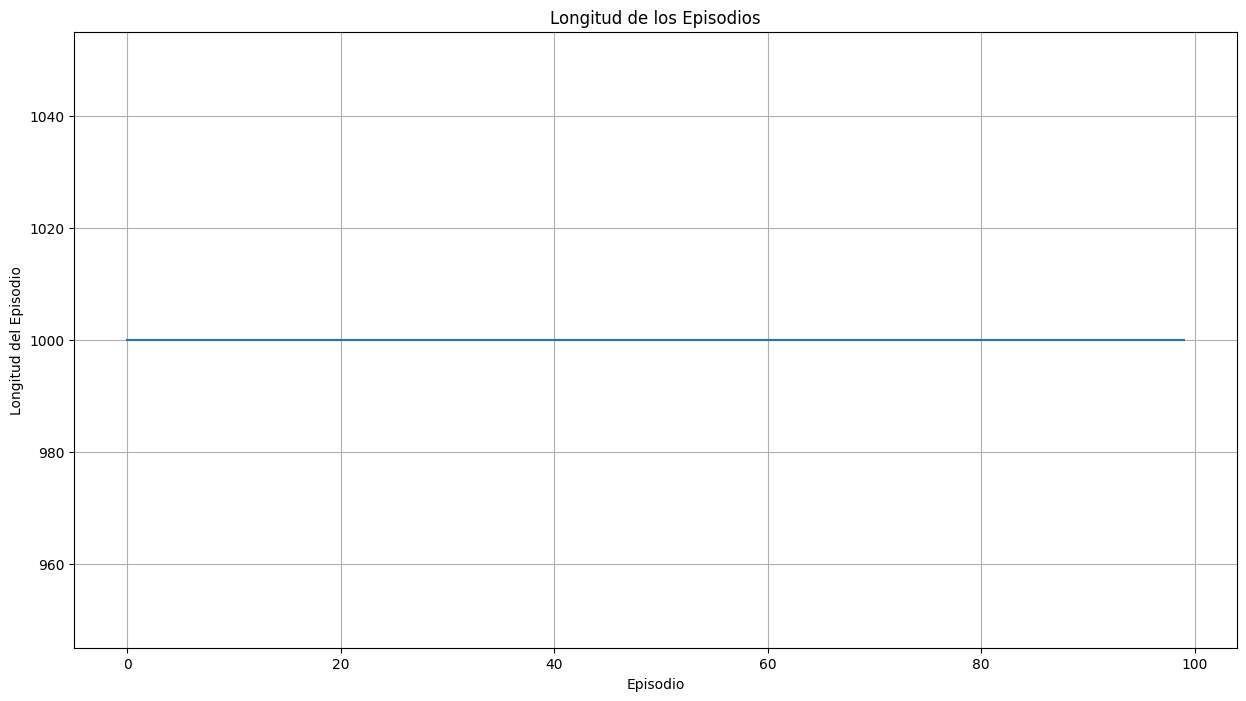

In [20]:
#@title Longitud de los episodios

plot_episode_lengths(episode_lengths)

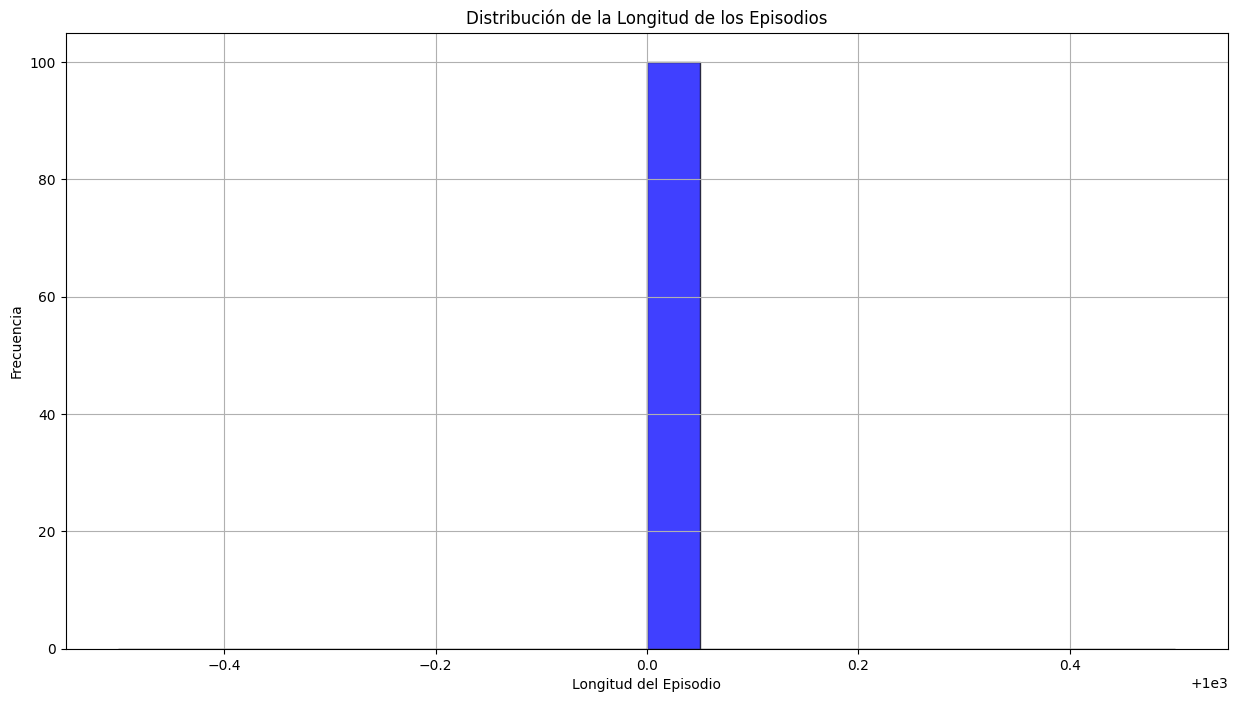

In [21]:
#@title Histograma con la longitud de los episodios

plot_episode_lengths_histogram(episode_lengths)

In [23]:
# @title Simulaciones en vídeo
import gymnasium as gym
from gymnasium.wrappers import RecordEpisodeStatistics, RecordVideo

# Solo grabamos 10 episodios, por ejemplo
trigger = lambda episode_id: episode_id < 10  # Graba solo los primeros 10 episodios

# Aplica el wrapper RecordVideo para grabar vídeos
env = gym.wrappers.RecordVideo(
    env,
    video_folder=video_folder,
    episode_trigger=trigger,  # Graba solo los primeros 10 episodios
)

num_episodes = 2 # Número de episodios a grabar
#observation, info = env.reset(seed=42)
for episode in range(num_episodes):
    observation, info = env.reset(seed=seed)
    episode_over = False
    while not episode_over:

        # Renderiza el frame actual, esto lo guardará en el archivo de video.
        env.render()

        # El agente elige la acción usando la política entrenada
        action = agent.get_action(observation)

        # Ejecuta un paso en el entorno con la acción seleccionada.
        # Obtiene la siguiente observación, la recompensa,
        # y si el episodio ha terminado (terminated) o ha sido truncado (truncated).
        observation, reward, terminated, truncated, info = env.step(action)

        # Verifica si el episodio ha terminado, ya sea por terminación o truncamiento.
        episode_over = terminated or truncated


env.close() # Importante cerrar el entorno, ¡esto finaliza la grabación de vídeo!
print(f"Grabación de episodios completada. Vídeos guardados en la carpeta '{video_folder}'")

/usr/local/lib/python3.11/dist-packages/gymnasium/wrappers/rendering.py:283: UserWarning: WARN: Overwriting existing videos at /content/videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
/usr/local/lib/python3.11/dist-packages/moviepy/config_defaults.py:1: DeprecationWarning: invalid escape sequence '\P'
  """


Grabación de episodios completada. Vídeos guardados en la carpeta 'videos'


In [24]:
latest_file = get_latest_episode_video_file(video_folder)
print(f"Último vídeo: {latest_file}") # outputs: ./video/rl-video-episode-4.mp4
embed_video(latest_file)

Último vídeo: videos/rl-video-episode-1.mp4
